In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
from scipy.misc import imread
import tensorflow as tf
import os

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.
D:\program\anaconda\envs\kr2.2.4tf1.13.1\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\program\anaconda\envs\kr2.2.4tf1.13.1\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\program\anaconda\envs\kr2.2.4tf1.13.1\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\program\anaconda\envs\kr2.2.4

In [2]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

Instructions for updating:
Colocations handled automatically by placer.


D:\git\ssd_keras\ssd.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1", padding="same")`
  name='conv1_1')(net['input'])
D:\git\ssd_keras\ssd.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same")`
  name='conv1_2')(net['conv1_1'])
D:\git\ssd_keras\ssd.py:44: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), strides=(2, 2), name="pool1", padding="same")`
  name='pool1')(net['conv1_2'])
D:\git\ssd_keras\ssd.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same")`
  name='conv2_1')(net['pool1'])
D:\git\ssd_keras\ssd.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2", padding="same")`
  name='conv2_2')(net['conv2_1'])
D:\git\ssd_keras\ssd.py:55: UserWarn

In [4]:
path = './pics/1.jpg'
img = cv2.imread(path,cv2.IMREAD_COLOR)
images = np.array([img])
print(img.shape)

(541, 960, 3)


In [5]:
# data(컬러,w,h)
def divide_by_grid(data, img_resolution=(300,300), grids=[1,2,4,7], margin_rate=0.3):
    img_w, img_h = data.shape[1:3]
    print(data.shape)
    new_data=[]
    new_coord=[]
    new_targets=[]
    for image in data:
        image=image.reshape(img_w, img_h, 3)
        for grid in grids:
            len_x = int(img_w/(grid-margin_rate*(grid-1)))
            len_y = int(img_h/(grid-margin_rate*(grid-1)))
            stride_x = int(len_x*(1-margin_rate))
            stride_y = int(len_y*(1-margin_rate))
            for idx_x in range(grid):
                for idx_y in range(grid):
                    p_x = idx_x*stride_x
                    p_y = idx_y*stride_y
                    new_coord.append([ p_x ,p_y,p_x+len_x,p_y+len_y])
                    image_sliced = image[p_x:p_x+len_x, p_y:p_y+len_y:]
                    image_sliced_resized=cv2.resize(image_sliced, img_resolution)
                    new_data.append(image_sliced_resized)

    return np.array(new_data),np.array(new_coord)

In [6]:
#이미지 그리드별 분할
grids=[1,2,4,7]
divided_images,coord = divide_by_grid(images, grids=grids)
print(divided_images.shape,coord.shape)

(1, 541, 960, 3)
(70, 300, 300, 3) (70, 4)


In [7]:
#image detection
preds = model.predict(divided_images, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

70/70 [==============================] - 83s 1s/step


D:\program\anaconda\envs\kr2.2.4tf1.13.1\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


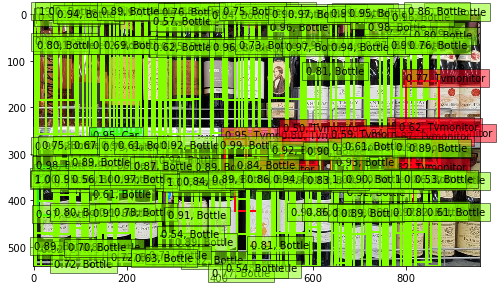

In [8]:
img = imread(path)
boxs=[]
scores=[]

#img = cv2.resize(img,(w,h))
plt.imshow(img / 255.)
#plt.imshow(img / 255.)
for i, img in enumerate(divided_images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    #print(det_conf)
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    #print(top_indices)
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    #print(img.shape)
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    currentAxis = plt.gca()
    
    x_rate = (coord[i][2]-coord[i][0])/300
    y_rate = (coord[i][3]-coord[i][1])/300
    for j in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[j] * img.shape[1])*x_rate)+coord[i][1]
        ymin = int(round(top_ymin[j] * img.shape[0])*y_rate)+coord[i][0]
        xmax = int(round(top_xmax[j] * img.shape[1])*x_rate)+coord[i][1]
        ymax = int(round(top_ymax[j] * img.shape[0])*y_rate)+coord[i][0]
        score = top_conf[j]    
        label = int(top_label_indices[j])
        label_name = voc_classes[label - 1]
        
        if label_name=='Bottle':
            boxs.append([xmin,ymin,xmax,ymax])
            scores.append(score)
            
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
plt.show()

In [9]:
selected_indices = tf.image.non_max_suppression(boxs, scores, len(scores), iou_threshold=0.4)
selected_boxes = tf.gather(boxs, selected_indices)
sess =tf.Session()
value=sess.run(selected_boxes)
print('Before : {} ----> After : {}'.format(len(scores),len(value)))

Before : 176 ----> After : 118


In [ ]:
plt.figure(figsize=(20,20))
maxnum=10
num=0
for i in range(len(value)):
    num=

def checkImgSet( x_sample, y_sample, filename_sample, classes=1, maxnum):
    for k in range(classes):
        plt.figure(figsize=(20,20))
    
        num=0
        for i in range(len(y_sample)):
            if num==maxnum:
                break
            if y_sample[i]==k:
                num+=1
                plt.subplot(10,10,num)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(x_sample[i], cmap='gray', vmin=0, vmax=255)
                #plt.imshow(cv2.cvtColor(x_sample[i], cv2.COLOR_BGR2RGB))
                if(filename_sample[i].find("test")>0):
                    tmp = filename_sample[i].find("test")
                else :
                    tmp = filename_sample[i].find("train")
                plt.xlabel(str(y_sample[i])+filename_sample[i][tmp:])
        plt.show()

In [26]:
img_path = []
x_y=[]

#img_path.append(path)
w=600
h=900
img = cv2.resize(img,(w,h))

#nms 가로 세로 설정.
nms_w=300
nms_h=300

nms_original_w=w/nms_w
nms_original_h=h/nms_h

#for문에 사용될 변수 설정
nms_w_j=int(1 +(w-nms_w)/(nms_w/2))
nms_h_i=int(1 +(h-nms_h)/(nms_h/2))


img_tmp = cv2.imread(path,cv2.IMREAD_COLOR)
img_tmp = cv2.resize(img,(300,300))
name = './pics/original.jpg'
img_path.append(name)
cv2.imwrite(name,img_tmp)

for i in range (1,nms_h_i+1):
    for j in range (1,nms_w_j+1):
        x=int((j-1)*(nms_w/2))
        y=int((i-1)*(nms_h/2))
        x_y.append([x,y])
        img_trim=img[y:y+nms_h,x:x+nms_w]
        name = './pics/'+str(x)+'_'+str(y)+'.jpg'
        cv2.imwrite(name,img_trim)
        img_path.append(name)


In [27]:
inputs = []
images = []
for each_img_path in img_path:
    img = image.load_img(each_img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(each_img_path))
    inputs.append(img.copy())
    
inputs = preprocess_input(np.array(inputs))
for each_img_path in img_path:
    os.remove(each_img_path)

D:\program\anaconda\envs\kr2.2.4tf1.13.1\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [28]:
preds = model.predict(inputs, batch_size=1, verbose=1)

16/16 [==============================] - 20s 1s/step


In [29]:
results = bbox_util.detection_out(preds)

In [30]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

Wall time: 18.9 s


(300, 300, 3)


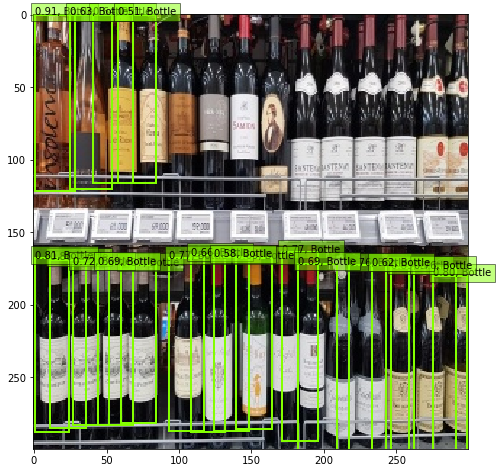

In [31]:
#분한 입력 전 결과
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    #print(det_conf)
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    #print(top_indices)
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    print(img.shape)
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    
    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    plt.show()
    break

D:\program\anaconda\envs\kr2.2.4tf1.13.1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


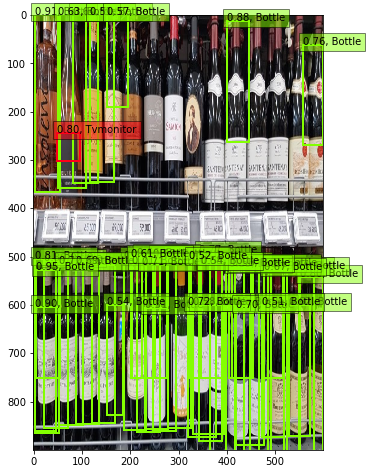

In [32]:
#분할 입력 후 결과
img = imread(path)
img = cv2.resize(img,(w,h))
plt.imshow(img / 255.)
index=-1
boxs=[]
scores=[]


for i, img in enumerate(images):
    index=index+1
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    #print(det_conf)
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    #print(top_indices)
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        #분할된 300*300를 900*900기준 좌표로 변환
        if index==0 :
            
            xmin = int(round(top_xmin[i] * img.shape[1]*nms_original_w)) 
            ymin = int(round(top_ymin[i] * img.shape[0]*nms_original_h))
            xmax = int(round(top_xmax[i] * img.shape[1]*nms_original_w))
            ymax = int(round(top_ymax[i] * img.shape[0]*nms_original_h))
            
        else :
            
            xmin = int(round(top_xmin[i] * img.shape[1])) + x_y[index-1][0]
            ymin = int(round(top_ymin[i] * img.shape[0])) + x_y[index-1][1]
            xmax = int(round(top_xmax[i] * img.shape[1])) + x_y[index-1][0]
            ymax = int(round(top_ymax[i] * img.shape[0])) + x_y[index-1][1]
            
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        
        #nms를 위한 데이터
        if label_name=='Bottle':
            boxs.append([xmin,ymin,xmax,ymax])
            scores.append(score)
        
        
        
        #matplot출력
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        #print(display_txt,coords,color)
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
plt.show()

Before : 42 ----> After : 36


D:\program\anaconda\envs\kr2.2.4tf1.13.1\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


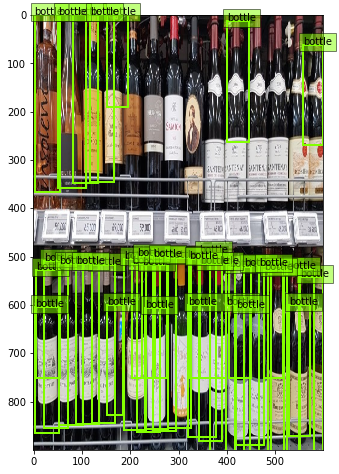

In [33]:
#print(len(boxs))
#from tf import tf.image.non_max_suppression 
selected_indices = tf.image.non_max_suppression(boxs, scores, len(scores), iou_threshold=0.6)
selected_boxes = tf.gather(boxs, selected_indices)
sess =tf.Session()
value=sess.run(selected_boxes)
print('Before : {} ----> After : {}'.format(len(scores),len(value)))

img = imread(path)
img = cv2.resize(img,(w,h))
plt.imshow(img / 255.)

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
currentAxis = plt.gca()

for each_box in value:
    xmin = each_box[0]
    ymin = each_box[1]
    xmax = each_box[2]
    ymax = each_box[3]
    
    display_txt = 'bottle'
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[5]
    #print(display_txt,coords,color)
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
plt.show()

In [96]:
# data(컬러,w,h)

def divide_by_grid(data, img_resolution=(112,112), grids=[1,2,4], margin_rate=0.3):
    img_w, img_h = data.shape[1:3]
    print(data.shape)
    new_data=[]
    new_coord=[]
    new_targets=[]
    for image in data:
        image=image.reshape(img_w, img_h, 3)
        for grid in grids:
            len_x = int(img_w/(grid-margin_rate*(grid-1)))
            len_y = int(img_h/(grid-margin_rate*(grid-1)))
            stride_x = int(len_x*(1-margin_rate))
            stride_y = int(len_y*(1-margin_rate))
            for idx_x in range(grid):
                for idx_y in range(grid):
                    p_x = idx_x*stride_x
                    p_y = idx_y*stride_y
                    new_coord.append([ p_x ,p_y,:p_x+len_x,p_y+len_y])
                    image_sliced = image[p_x:p_x+len_x, p_y:p_y+len_y:]
                    image_sliced_resized=cv2.resize(image_sliced, img_resolution)
                    new_data.append(image_sliced_resized)

    return np.array(new_data),np.array(new_coord)

In [97]:
images = np.array([img, img])


In [102]:
grids=[1,2,3]
images_divided = divide_by_grid(images, grids=grids)

(2, 900, 600, 3)


(42, 112, 112, 3)

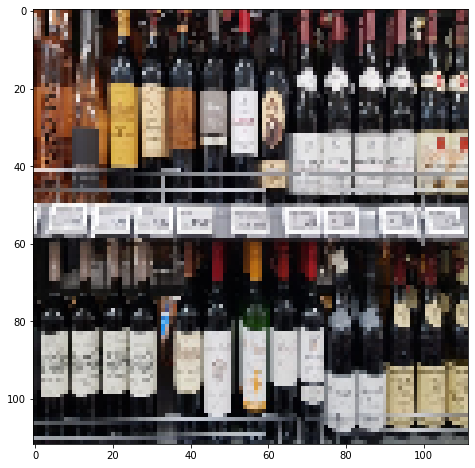

In [101]:
for i in range()
plt.imshow(images_divided[0])

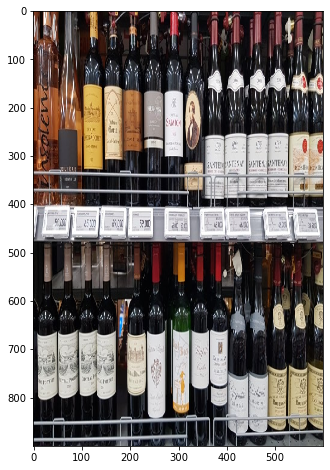

In [40]:
plt.imshow(img)